In [1]:
###   Imports and Logging   ###
import sys
import logging
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import __version__ as pltver
import matplotlib.ticker as ticker
from skaero.atmosphere import coesa
from skaero import __version__ as skver


logging.basicConfig(
    level=logging.DEBUG,
    format=' %(asctime)s -  %(levelname)s -  %(message)s'
)

logging.info('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')
logging.info('Python version: {}'.format(sys.version))
logging.info('Author: Benjamin Crews')
logging.info('Numpy version: {}'.format(np.version.version))
logging.info('Pandas version: {}'.format(pd.__version__))
logging.info('Matplotlib version: {}'.format(pltver))
logging.info('SciKit-Aero version: {}'.format(skver))
logging.info('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')

 2020-02-10 21:13:06,213 -  INFO -  =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
 2020-02-10 21:13:06,215 -  INFO -  Python version: 3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
 2020-02-10 21:13:06,215 -  INFO -  Author: Benjamin Crews
 2020-02-10 21:13:06,216 -  INFO -  Numpy version: 1.16.2
 2020-02-10 21:13:06,216 -  INFO -  Pandas version: 0.24.2
 2020-02-10 21:13:06,217 -  INFO -  Matplotlib version: 3.0.3
 2020-02-10 21:13:06,217 -  INFO -  SciKit-Aero version: 0.1
 2020-02-10 21:13:06,217 -  INFO -  =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
 2020-02-10 21:13:06,218 -  DEBUG -  Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [17]:
#####################
###   Functions   ###
#####################
def thrust_Ct_mom(T: float,
                  R: float,
                  rho: float,
                  Omega: float
                 ) -> float:
    '''
    Calculates the thrust coefficient based on momentum theory.
    
    Ensure consistent units are used!
    '''
    return T/(math.pi*R**2*rho*(Omega*R)**2)


def local_solidity(b: int,
                   c: float,
                   x: float,
                   R: float
                  ):
    '''
    Calculates the local solidity at blade station 'x' based on the blade geometry.
    '''
    # TODO: Lookup local chord based on x and chord function definition.
    # (c: function instead of c: float)
    return b*c/(math.pi*R)

In [32]:
#######################################
###   Input Rotor Characteristics   ###
#######################################
D = 35            # [ft]
R = D/2           # [ft]
b = 4             # [ ]
CHORD = 10.4/12   # [ft]
atm = coesa.table(0) # an atmosphere at 0 height
rho = atm[3]/515   # [slugs/ft3] ; coesa returns rho in SI units (kg/m3)/515 = slugs/ft3
OMEGA = 756/R     # [rad/sec]

THRUST = np.linspace(0, 5000, num=20)

In [33]:
# Initialize a dataframe with the thrust
df = pd.DataFrame(data=THRUST, columns=['Thrust [lbs]'])

print('First, Calculate Ct from Momentum Theory: Ct = {:.5f}, @ T = 5000\n'.format(thrust_Ct_mom(5000, R, rho, OMEGA)))
df['Ct'] = df.apply(thrust_Ct_mom, args=(R, rho, OMEGA))
print(df)

First, Calculate Ct from Momentum Theory: Ct = 0.00382, @ T = 5000

    Thrust [lbs]        Ct
0       0.000000  0.000000
1     263.157895  0.000201
2     526.315789  0.000402
3     789.473684  0.000604
4    1052.631579  0.000805
5    1315.789474  0.001006
6    1578.947368  0.001207
7    1842.105263  0.001408
8    2105.263158  0.001610
9    2368.421053  0.001811
10   2631.578947  0.002012
11   2894.736842  0.002213
12   3157.894737  0.002414
13   3421.052632  0.002616
14   3684.210526  0.002817
15   3947.368421  0.003018
16   4210.526316  0.003219
17   4473.684211  0.003420
18   4736.842105  0.003622
19   5000.000000  0.003823


In [34]:
print('Next, Calculate the solidity, which is constant for a constant-chord blade:\n')
df['Solidity'] = local_solidity(b, CHORD, 1, R)
print(df)

Next, Calculate the solidity, which is constant for a constant-chord blade:

    Thrust [lbs]        Ct  Solidity
0       0.000000  0.000000  0.063056
1     263.157895  0.000201  0.063056
2     526.315789  0.000402  0.063056
3     789.473684  0.000604  0.063056
4    1052.631579  0.000805  0.063056
5    1315.789474  0.001006  0.063056
6    1578.947368  0.001207  0.063056
7    1842.105263  0.001408  0.063056
8    2105.263158  0.001610  0.063056
9    2368.421053  0.001811  0.063056
10   2631.578947  0.002012  0.063056
11   2894.736842  0.002213  0.063056
12   3157.894737  0.002414  0.063056
13   3421.052632  0.002616  0.063056
14   3684.210526  0.002817  0.063056
15   3947.368421  0.003018  0.063056
16   4210.526316  0.003219  0.063056
17   4473.684211  0.003420  0.063056
18   4736.842105  0.003622  0.063056
19   5000.000000  0.003823  0.063056


In [35]:
print('Next, Calculate the tip-loss factor: B = {:.5f}, @ T = 5000\n'.format(1-math.sqrt(2*0.003823)/b))
df['B'] = 1 - np.sqrt(2*df.Ct)/b
print(df)

Next, Calculate the tip-loss factor: B = 0.97814, @ T = 5000

    Thrust [lbs]        Ct  Solidity         B
0       0.000000  0.000000  0.063056  1.000000
1     263.157895  0.000201  0.063056  0.994985
2     526.315789  0.000402  0.063056  0.992908
3     789.473684  0.000604  0.063056  0.991314
4    1052.631579  0.000805  0.063056  0.989970
5    1315.789474  0.001006  0.063056  0.988786
6    1578.947368  0.001207  0.063056  0.987716
7    1842.105263  0.001408  0.063056  0.986732
8    2105.263158  0.001610  0.063056  0.985816
9    2368.421053  0.001811  0.063056  0.984955
10   2631.578947  0.002012  0.063056  0.984141
11   2894.736842  0.002213  0.063056  0.983367
12   3157.894737  0.002414  0.063056  0.982628
13   3421.052632  0.002616  0.063056  0.981918
14   3684.210526  0.002817  0.063056  0.981236
15   3947.368421  0.003018  0.063056  0.980577
16   4210.526316  0.003219  0.063056  0.979940
17   4473.684211  0.003420  0.063056  0.979323
18   4736.842105  0.003622  0.063056  0.97872

In [36]:
d_0 = 0.0087
d_1 = -0.0216
d_2 = 0.4
print('For the 3 drag coefficients, empirical values will be uses: {}, {}, {}\n'.format(d_0, d_1, d_2))

print('Finally, Cq can be calculated!')
df['Cq'] = 0.5 * df.Ct * np.sqrt(0**2 + 2*df.Ct/df.B**2) + 0.5*0 + df.Solidity*d_0/8 \
            + 2*d_1*df.Ct/(3*2*math.pi*df.B**2) + (4*d_2/(df.Solidity*2*math.pi))*(df.Ct/df.B)**2

print(df)

For the 3 drag coefficients, empirical values will be uses: 0.0087, -0.0216, 0.4

Finally, Cq can be calculated!
    Thrust [lbs]        Ct  Solidity         B        Cq
0       0.000000  0.000000  0.063056  1.000000  0.000069
1     263.157895  0.000201  0.063056  0.994985  0.000070
2     526.315789  0.000402  0.063056  0.992908  0.000074
3     789.473684  0.000604  0.063056  0.991314  0.000079
4    1052.631579  0.000805  0.063056  0.989970  0.000086
5    1315.789474  0.001006  0.063056  0.988786  0.000093
6    1578.947368  0.001207  0.063056  0.987716  0.000102
7    1842.105263  0.001408  0.063056  0.986732  0.000111
8    2105.263158  0.001610  0.063056  0.985816  0.000122
9    2368.421053  0.001811  0.063056  0.984955  0.000133
10   2631.578947  0.002012  0.063056  0.984141  0.000146
11   2894.736842  0.002213  0.063056  0.983367  0.000159
12   3157.894737  0.002414  0.063056  0.982628  0.000173
13   3421.052632  0.002616  0.063056  0.981918  0.000187
14   3684.210526  0.002817  0.06

In [37]:
print('And the last value to be calculated is the Figure of Merit, M:')

df['M'] = (1/math.sqrt(2))*(df.Ct**(3/2)/df.Cq)
print(df)

And the last value to be calculated is the Figure of Merit, M:
    Thrust [lbs]        Ct  Solidity         B        Cq         M
0       0.000000  0.000000  0.063056  1.000000  0.000069  0.000000
1     263.157895  0.000201  0.063056  0.994985  0.000070  0.028705
2     526.315789  0.000402  0.063056  0.992908  0.000074  0.077079
3     789.473684  0.000604  0.063056  0.991314  0.000079  0.132327
4    1052.631579  0.000805  0.063056  0.989970  0.000086  0.188446
5    1315.789474  0.001006  0.063056  0.988786  0.000093  0.242044
6    1578.947368  0.001207  0.063056  0.987716  0.000102  0.291345
7    1842.105263  0.001408  0.063056  0.986732  0.000111  0.335604
8    2105.263158  0.001610  0.063056  0.985816  0.000122  0.374699
9    2368.421053  0.001811  0.063056  0.984955  0.000133  0.408857
10   2631.578947  0.002012  0.063056  0.984141  0.000146  0.438482
11   2894.736842  0.002213  0.063056  0.983367  0.000159  0.464048
12   3157.894737  0.002414  0.063056  0.982628  0.000173  0.486035

In [ ]:
print('Now, blade angles can be calculated.\nFirst, inflow angle, phi, at the blade tip:\n')
# Note, that these calculations are only for hover, so a zero replaces the Vclimb terms
df['phi_t [rad]'] = 0.5 * np.sqrt(0**2 + 2*df.Ct/df.B**2) + 0.5*0
df['phi_t [deg]'] = np.rad2deg(df['phi_t [rad]'])
print(df)

print('Values don\'t seem unreasonable, so we can carry on.')

In [ ]:
print('And now, blade angle, theta, at the tip:')
print('Note: 2pi is used for lift-curve slope (a).')
df['theta_t [rad]'] = 0.5 * np.sqrt(0**2 + 2*df.Ct/df.B**2) + 4/(df.Solidity*2*math.pi)*(df.Ct/df.B**2)
df['theta_t [deg]'] = np.rad2deg(df['theta_t [rad]'])
print(df)

 2020-02-10 22:13:55,418 -  DEBUG -  update_title_pos
 2020-02-10 22:13:55,575 -  DEBUG -  update_title_pos
 2020-02-10 22:13:55,638 -  DEBUG -  update_title_pos
 2020-02-10 22:13:55,739 -  DEBUG -  update_title_pos
 2020-02-10 22:13:55,793 -  DEBUG -  update_title_pos
 2020-02-10 22:13:55,822 -  DEBUG -  update_title_pos


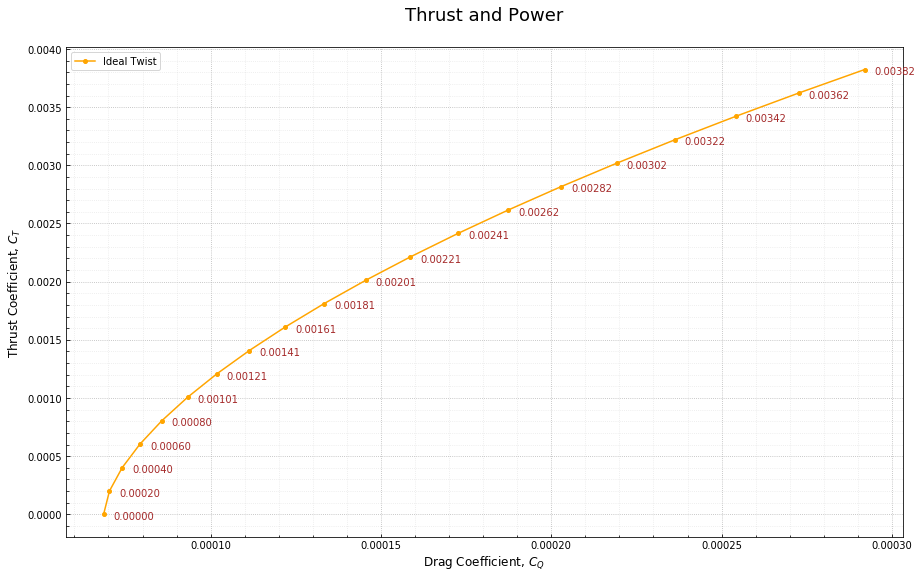

In [42]:
################################
###   Plotting the Results   ###
################################
fig, ax = plt.subplots(figsize=(15,9))

# Add the data and color it
ax.plot(df.Cq, df.Ct, color='orange', label='Ideal Twist', marker='o', markersize='4')
ax.legend()

# Axis labels
ax.set_xlabel('Drag Coefficient, $C_Q$', fontsize=12)
ax.set_ylabel('Thrust Coefficient, $C_T$', fontsize=12)
ax.set_title('Thrust and Power\n', fontsize=18)

# Move the axis and its label to the top
# ax.xaxis.set_label_position('top')
# ax.xaxis.tick_top()

# Set the ticks
ax.xaxis.set_major_locator(ticker.AutoLocator())
ax.tick_params(which='minor', width=0.75, length=2.5)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(axis='both', which='both', direction='in')

# Set the grid lines
ax.grid(b=True, which='major', linestyle=':')
ax.grid(b=True, which='minor', linestyle=':', alpha=0.3)

# Set the data labels
for i,v in zip(df.Cq, df.Ct):
    label = '{:.5f}'.format(v)
    ax.annotate(label,
                (i,v),
                textcoords='offset points',
                xytext=(10,-5),
                ha='left',
                color='brown'
                )
    
fig.savefig('Blade-Element_Thrust_and_Power.png')